In [44]:
using PowerSystems
using InfrastructureSystems
using Dates
using DataStructures
using Plots, Printf

In [2]:
file_dir = joinpath("/projects", "emco4286", "data", "sienna_data", "input", "DA_sys", "final_sys_DA.json")
sys = System(file_dir)

┌ Info: Loaded time series from storage file existing=/projects/emco4286/data/sienna_data/input/DA_sys/final_sys_DA_time_series_storage.h5 new=/projects/emco4286/code-server/tmp/jl_SZhgto compression=CompressionSettings(false, CompressionTypes.DEFLATE = 1, 3, true)
└ @ InfrastructureSystems /projects/emco4286/.julia/packages/InfrastructureSystems/LEg3t/src/hdf5_time_series_storage.jl:110
┌ Warning: Invalid range
│   valid_info.struct_name = ThermalStandard
│   field_name = active_power
│   valid_range = active_power_limits
│   valid_info.ist_struct = ThermalStandard(gen-472, true, true, ACBus(7376, CHANNELVIEW 1 10, ACBusTypes.PV = 2, -0.40225807547897185, 1.04, (min = 0.9, max = 1.1), 18.0, Area(Coast, 202.78914140625, 0.0, 0.0, Dict{String, Any}()), LoadZone(4, 43.636300000000006, 12.363500000000004, Dict{String, Any}()), Dict{String, Any}("x" => -95.10269000000001, "y" => 29.802043474614997)), 0.008333408956849222, 0.0, 2.0608130919615197, (min = 0.551, max = 1.8366), (min = -0.2039

Property,Value
Name,
Description,
System Units Base,SYSTEM_BASE
Base Power,100.0
Base Frequency,60.0
Num Components,10247
Type,Count
ACBus,2103
Arc,2834
Area,8


In [28]:
set_units_base_system!(sys, "NATURAL_UNITS")

In [31]:
gens = reduce(vcat, [collect(get_components(ThermalStandard, sys)), collect(get_components(ThermalMultiStart, sys))]) #, collect(get_components(RenewableDispatch, sys))])

mydict = Dict(4 => 0., 20 => 0., 12 => 0., 8 => 0.) # , 22 => 0., 21 => 0.)

for g in gens

    pm_val = get_prime_mover_type(g).value
    rating = get_rating(g) #*get_base_power(g)

    # if pm_val == 21
    #     rating /=100
    # end

    mydict[pm_val] = mydict[pm_val] + rating
end

In [39]:
round(sum(collect(values(mydict)))/1000)

128.0

In [56]:
collect(cgrad(:batlow10, 4, categorical=true))

4-element Vector{Any}:
 RGBA{Float64}(0.0052, 0.0982, 0.3498, 1.0)
 RGBA{Float64}(0.2344, 0.4258, 0.3359, 1.0)
 RGBA{Float64}(0.8203, 0.5742, 0.2617, 1.0)
 RGBA{Float64}(0.9766, 0.7969, 0.9766, 1.0)

In [60]:
# pie(["Wind turbine", "Combined-cycle unit", "Steam turbine", "PV plant", "Gas turbine", "Combustion turbine"], collect(values(mydict)))
data = collect(values(mydict))
tot = sum(data)
datapct = [@sprintf("%.1f%%", x/tot*100) for x in data]

θ = (cumsum(data) - data/2) .* 360/sum(data)
scθ = sincosd.(θ)

p = pie(["Combined-cycle unit", "Steam turbine", "Gas turbine", "Combustion turbine"], data, title=@sprintf("%s MW total thermal capacity", round(Int32, tot/1000)), palette=collect(cgrad(:batlow10, 10, categorical=true))[begin+2:2:end])
for (s, sci) in zip(datapct, scθ)
    annotate!(0.6*sci[2], 0.6*sci[1], text(s, 9, :black))
end
p
savefig("tamu_sys_thermal_capacity_pie.png")

"/home/emco4286/ercot-sienna/notebooks/tamu_sys_thermal_capacity_pie.png"

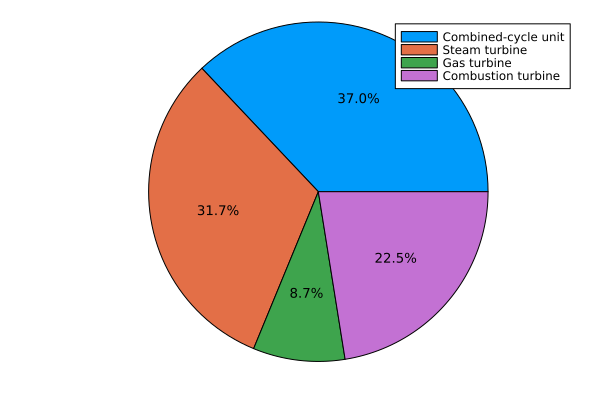

In [46]:
p

In [34]:
prime_movers = get_prime_mover_type.(gens)

354-element Vector{PrimeMovers}:
 PrimeMovers.GT = 12
 PrimeMovers.ST = 20
 PrimeMovers.GT = 12
 PrimeMovers.ST = 20
 PrimeMovers.GT = 12
 PrimeMovers.CC = 4
 PrimeMovers.ST = 20
 PrimeMovers.ST = 20
 PrimeMovers.CC = 4
 PrimeMovers.GT = 12
 ⋮
 PrimeMovers.CT = 8
 PrimeMovers.CC = 4
 PrimeMovers.ST = 20
 PrimeMovers.CC = 4
 PrimeMovers.CT = 8
 PrimeMovers.ST = 20
 PrimeMovers.GT = 12
 PrimeMovers.GT = 12
 PrimeMovers.CT = 8

In [7]:
unique(prime_movers)

2-element Vector{PrimeMovers}:
 PrimeMovers.WT = 22
 PrimeMovers.PVe = 21

In [7]:
[count(==(element),prime_movers) for element in unique(prime_movers) ]

4-element Vector{Int64}:
 88
 91
 83
 87

In [4]:
get_name.(get_components(PowerLoad, sys))

1125-element Vector{String}:
 "EAST BERNARD_LOAD_1"
 "YORKTOWN_LOAD_1"
 "MCALLEN_LOAD_2"
 "MISSION_LOAD_3"
 "PFLUGERVILLE_LOAD_1"
 "KERENS_LOAD_1"
 "HOUSTON_LOAD_54"
 "HOUSTON_LOAD_11"
 "DALLAS_LOAD_28"
 "HOLLAND_LOAD_1"
 ⋮
 "PASADENA_LOAD_5"
 "ATHENS_LOAD_2"
 "HOUSTON_LOAD_46"
 "COLLEYVILLE_LOAD_1"
 "FREDERICKSBURG_LOAD_1"
 "HOUSTON_LOAD_69"
 "WICHITA FALLS_LOAD_1"
 "STRAWN_LOAD_1"
 "OLNEY_LOAD_1"

In [3]:
component = get_component(PowerLoad, sys, "EAST BERNARD_LOAD_1")
my_keys = get_time_series_keys(component)
ts_sorted_dict = get_time_series(component, my_keys[1]).data

SortedDict{DateTime, Vector{Float64}, Base.Order.ForwardOrdering} with 365 entries:
  DateTime("2018-01-01T00:00:00") => [0.545264, 0.540462, 0.539975, 0.53939, 0.…
  DateTime("2018-01-02T00:00:00") => [0.614196, 0.597481, 0.588006, 0.583615, 0…
  DateTime("2018-01-03T00:00:00") => [0.655463, 0.641155, 0.635748, 0.638102, 0…
  DateTime("2018-01-04T00:00:00") => [0.614471, 0.603508, 0.598795, 0.599309, 0…
  DateTime("2018-01-05T00:00:00") => [0.53063, 0.514094, 0.506398, 0.502795, 0.…
  DateTime("2018-01-06T00:00:00") => [0.530447, 0.516424, 0.510684, 0.509083, 0…
  DateTime("2018-01-07T00:00:00") => [0.472708, 0.458938, 0.449947, 0.44571, 0.…
  DateTime("2018-01-08T00:00:00") => [0.435066, 0.416936, 0.407254, 0.401678, 0…
  DateTime("2018-01-09T00:00:00") => [0.46175, 0.445542, 0.43745, 0.436947, 0.4…
  DateTime("2018-01-10T00:00:00") => [0.471751, 0.453223, 0.444382, 0.439933, 0…
  DateTime("2018-01-11T00:00:00") => [0.4448, 0.424127, 0.412499, 0.40638, 0.40…
  DateTime("2018-01-12T00

In [13]:
my_keys2 = collect(keys(ts_sorted_dict))

365-element Vector{DateTime}:
 2018-01-01T00:00:00
 2018-01-02T00:00:00
 2018-01-03T00:00:00
 2018-01-04T00:00:00
 2018-01-05T00:00:00
 2018-01-06T00:00:00
 2018-01-07T00:00:00
 2018-01-08T00:00:00
 2018-01-09T00:00:00
 2018-01-10T00:00:00
 ⋮
 2018-12-23T00:00:00
 2018-12-24T00:00:00
 2018-12-25T00:00:00
 2018-12-26T00:00:00
 2018-12-27T00:00:00
 2018-12-28T00:00:00
 2018-12-29T00:00:00
 2018-12-30T00:00:00
 2018-12-31T00:00:00

In [10]:
const PSY = PowerSystems

PowerSystems

In [11]:
PSY.transform_single_time_series!(sys, Hour(48), Hour(24))

In [12]:
component = get_component(PowerLoad, sys, "EAST BERNARD_LOAD_1")
my_keys = get_time_series_keys(component)
ts_sorted_dict = get_time_series(component, my_keys[1]).data

SortedDict{DateTime, Vector{Float64}, Base.Order.ForwardOrdering} with 365 entries:
  DateTime("2018-01-01T00:00:00") => [0.545264, 0.540462, 0.539975, 0.53939, 0.…
  DateTime("2018-01-02T00:00:00") => [0.614196, 0.597481, 0.588006, 0.583615, 0…
  DateTime("2018-01-03T00:00:00") => [0.655463, 0.641155, 0.635748, 0.638102, 0…
  DateTime("2018-01-04T00:00:00") => [0.614471, 0.603508, 0.598795, 0.599309, 0…
  DateTime("2018-01-05T00:00:00") => [0.53063, 0.514094, 0.506398, 0.502795, 0.…
  DateTime("2018-01-06T00:00:00") => [0.530447, 0.516424, 0.510684, 0.509083, 0…
  DateTime("2018-01-07T00:00:00") => [0.472708, 0.458938, 0.449947, 0.44571, 0.…
  DateTime("2018-01-08T00:00:00") => [0.435066, 0.416936, 0.407254, 0.401678, 0…
  DateTime("2018-01-09T00:00:00") => [0.46175, 0.445542, 0.43745, 0.436947, 0.4…
  DateTime("2018-01-10T00:00:00") => [0.471751, 0.453223, 0.444382, 0.439933, 0…
  DateTime("2018-01-11T00:00:00") => [0.4448, 0.424127, 0.412499, 0.40638, 0.40…
  DateTime("2018-01-12T00

In [12]:
therm_stand_pm = get_prime_mover_type.(get_components(ThermalStandard, sys))
[(element, count(==(element),therm_stand_pm)) for element in unique(therm_stand_pm) ]

2-element Vector{Tuple{PrimeMovers, Int64}}:
 (PrimeMovers.GT = 12, 3)
 (PrimeMovers.ST = 20, 2)

In [13]:
# https://nrel-sienna.github.io/PowerSystems.jl/stable/api/enumerated_types/#pm_list
therm_multi_pm = get_prime_mover_type.(get_components(ThermalMultiStart, sys))
[(element, count(==(element),therm_multi_pm)) for element in unique(therm_multi_pm) ]

4-element Vector{Tuple{PrimeMovers, Int64}}:
 (PrimeMovers.CC = 4, 88)
 (PrimeMovers.ST = 20, 91)
 (PrimeMovers.GT = 12, 83)
 (PrimeMovers.CT = 8, 87)

In [25]:
prime_movers = get_prime_mover_type.(get_components(ThermalMultiStart, sys))

349-element Vector{PrimeMovers}:
 PrimeMovers.CC = 4
 PrimeMovers.ST = 20
 PrimeMovers.ST = 20
 PrimeMovers.CC = 4
 PrimeMovers.GT = 12
 PrimeMovers.CT = 8
 PrimeMovers.ST = 20
 PrimeMovers.CC = 4
 PrimeMovers.CC = 4
 PrimeMovers.GT = 12
 ⋮
 PrimeMovers.CT = 8
 PrimeMovers.CC = 4
 PrimeMovers.ST = 20
 PrimeMovers.CC = 4
 PrimeMovers.CT = 8
 PrimeMovers.ST = 20
 PrimeMovers.GT = 12
 PrimeMovers.GT = 12
 PrimeMovers.CT = 8

In [30]:
prime_movers[6]

PrimeMovers.CT = 8

In [34]:
collect(get_components(ThermalMultiStart, sys))[6]

ThermalMultiStart: MAGIC_VALLEY_STATION_CC1:
   name: MAGIC_VALLEY_STATION_CC1
   available: true
   status: true
   bus: ACBus: BROWNSVILLE 1 0
   active_power: 0.00455531453362256
   reactive_power: 0.21270000000000006
   rating: 4.2873
   prime_mover_type: PrimeMovers.CT = 8
   fuel: ThermalFuels.NATURAL_GAS = 7
   active_power_limits: (min = 2.1, max = 3.8400000000000003)
   reactive_power_limits: (min = -0.23511, max = 1.9362000000000001)
   ramp_limits: (up = 0.646322, down = 0.643556)
   power_trajectory: (startup = 3.8400000000000003, shutdown = 3.8400000000000003)
   time_limits: (up = 1.0, down = 1.0)
   start_time_limits: (hot = 0.0, warm = 0.0, cold = 1.0)
   start_types: 1
   operation_cost: ThermalGenerationCost composed of variable: CostCurve{PiecewiseIncrementalCurve}
   base_power: 461.0
   services: 3-element Vector{Service}
   time_at_status: 8760.0
   must_run: false
   dynamic_injector: nothing
   ext: Dict{String, Any}("ERCOT_FUEL" => "CCGT90")
   InfrastructureSy

In [38]:
ct_units = filter(c -> get_prime_mover_type(c).value == 8, collect(get_components(ThermalMultiStart, sys)))

87-element Vector{ThermalMultiStart}:
 ThermalMultiStart(MAGIC_VALLEY_STATION_CC1, true, true, ACBus(4192, BROWNSVILLE 1 0, ACBusTypes.PV = 2, -0.8853350007816504, 1.02, (min = 0.9, max = 1.1), 230.0, Area(Southern, 68.18843299999999, 0.0, 0.0, Dict{String, Any}()), LoadZone(19, 38.702100000000016, 10.966, Dict{String, Any}()), Dict{String, Any}("x" => -97.51060000000001, "y" => 25.906623725411485)), 0.00455531453362256, 0.21270000000000006, 4.2873, PrimeMovers.CT = 8, ThermalFuels.NATURAL_GAS = 7, (min = 2.1, max = 3.8400000000000003), (min = -0.23511, max = 1.9362000000000001), (up = 0.646322, down = 0.643556), (startup = 3.8400000000000003, shutdown = 3.8400000000000003), (up = 1.0, down = 1.0), (hot = 0.0, warm = 0.0, cold = 1.0), 1, ThermalGenerationCost(CostCurve{PiecewiseIncrementalCurve}(PiecewiseIncrementalCurve(0.66, [120.0, 210.0, 304.5, 312.0, 318.0, 320.0, 321.0, 324.0, 325.1, 326.0], [16.920000000000073, 23.669999999996417, 76.06999999997787, 201.15999999995412, 483.64999

In [41]:
unique(get_fuel.(ct_units))

1-element Vector{ThermalFuels}:
 ThermalFuels.NATURAL_GAS = 7

In [ ]:
[c.value == 8 ? c : 0 for c in get_prime_mover_type.(get_components(ThermalMultiStart, sys))]

349-element Vector{Any}:
 0
 0
 0
 0
 0
  PrimeMovers.CT = 8
 0
 0
 0
 0
 ⋮
  PrimeMovers.CT = 8
 0
 0
 0
  PrimeMovers.CT = 8
 0
 0
 0
  PrimeMovers.CT = 8

In [ ]:
therm_stand_pm = get_prime_mover_type.(get_components(ThermalStandard, sys))
[(element, count(==(element),therm_stand_pm)) for element in unique(therm_stand_pm) ]

2-element Vector{Tuple{PrimeMovers, Int64}}:
 (PrimeMovers.GT = 12, 3)
 (PrimeMovers.ST = 20, 2)

In [16]:
wst = get_component(Area, sys, "West")

Area: West:
   name: West
   peak_active_power: 24.520962963867195
   peak_reactive_power: 0.0
   load_response: 0.0
   ext: Dict{String, Any}()
   InfrastructureSystems.SystemUnitsSettings:
      base_value: 100.0
      unit_system: UnitSystem.SYSTEM_BASE = 0
   has_supplemental_attributes: false
   has_time_series: true

In [65]:
get_load_response(wst)

0.0

In [67]:
get_peak_reactive_power(wst)

0.0

In [68]:
get_ext(wst)

Dict{String, Any}()

In [49]:
get_buses(sys, wst)

170-element Vector{ACBus}:
 ACBus(3146, JUNCTION 0, ACBusTypes.PQ = 1, -0.6229066137733746, 1.0165387, (min = 0.9, max = 1.1), 115.0, Area(West, 24.520962963867195, 0.0, 0.0, Dict{String, Any}()), LoadZone(28, 6.9548000000000005, 1.9703000000000002, Dict{String, Any}()), Dict{String, Any}("x" => -100.06015, "y" => 30.452463437998798))
 ACBus(3040, BALLINGER 0, ACBusTypes.PQ = 1, -0.6015359821072077, 0.9901182, (min = 0.9, max = 1.1), 115.0, Area(West, 24.520962963867195, 0.0, 0.0, Dict{String, Any}()), LoadZone(27, 9.801000000000002, 2.7766999999999995, Dict{String, Any}()), Dict{String, Any}("x" => -99.92516199999999, "y" => 31.732452506296504))
 ACBus(3067, TRENT 1 0, ACBusTypes.PQ = 1, -0.3464033855315336, 1.0257376, (min = 0.9, max = 1.1), 115.0, Area(West, 24.520962963867195, 0.0, 0.0, Dict{String, Any}()), LoadZone(27, 9.801000000000002, 2.7766999999999995, Dict{String, Any}()), Dict{String, Any}("x" => -100.22665200000002, "y" => 32.4240226617666))
 ACBus(3070, NOLAN 0, ACBusTyp

In [50]:
jnctn = get_component(ACBus, sys, "JUNCTION 0")

ACBus: JUNCTION 0:
   number: 3146
   name: JUNCTION 0
   bustype: ACBusTypes.PQ = 1
   angle: -0.6229066137733746
   magnitude: 1.0165387
   voltage_limits: (min = 0.9, max = 1.1)
   base_voltage: 115.0
   area: Area: West
   load_zone: LoadZone: 28
   ext: Dict{String, Any}("x" => -100.06015, "y" => 30.452463437998798)
   InfrastructureSystems.SystemUnitsSettings:
      base_value: 100.0
      unit_system: UnitSystem.SYSTEM_BASE = 0
   has_supplemental_attributes: false
   has_time_series: false

In [59]:
get_area(jnctn)

Area: West:
   name: West
   peak_active_power: 24.520962963867195
   peak_reactive_power: 0.0
   load_response: 0.0
   ext: Dict{String, Any}()
   InfrastructureSystems.SystemUnitsSettings:
      base_value: 100.0
      unit_system: UnitSystem.SYSTEM_BASE = 0
   has_supplemental_attributes: false
   has_time_series: true

In [69]:
get_ext(jnctn)

Dict{String, Any} with 2 entries:
  "x" => -100.06
  "y" => 30.4525

In [ ]:
get_load_zone(jnctn)

UndefVarError: UndefVarError: `get_load` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [61]:
get_loads(jnctn)

UndefVarError: UndefVarError: `get_loads` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
get_name.(get_components(PowerLoad, sys))

1125-element Vector{String}:
 "EAST BERNARD_LOAD_1"
 "YORKTOWN_LOAD_1"
 "MCALLEN_LOAD_2"
 "MISSION_LOAD_3"
 "PFLUGERVILLE_LOAD_1"
 "KERENS_LOAD_1"
 "HOUSTON_LOAD_54"
 "HOUSTON_LOAD_11"
 "DALLAS_LOAD_28"
 "HOLLAND_LOAD_1"
 ⋮
 "PASADENA_LOAD_5"
 "ATHENS_LOAD_2"
 "HOUSTON_LOAD_46"
 "COLLEYVILLE_LOAD_1"
 "FREDERICKSBURG_LOAD_1"
 "HOUSTON_LOAD_69"
 "WICHITA FALLS_LOAD_1"
 "STRAWN_LOAD_1"
 "OLNEY_LOAD_1"

In [63]:
jnctn_load = get_component(PowerLoad, sys, "JUNCTION_LOAD")

In [37]:
keys = get_time_series_keys(wst)
forecast = get_time_series(wst, keys[1])

Deterministic("max_active_power", DataStructures.SortedDict(DateTime("2018-01-01T00:00:00") => [0.809706235460046, 0.8038323550852321, 0.8008606670462621, 0.791647259269729, 0.7870148429669462, 0.7841225572535393, 0.7997309138322644, 0.8226539918571323, 0.844621503964018, 0.836166226605039  …  0.752497880423369, 0.7514420535124815, 0.7500491027466019, 0.7560093051480781, 0.779218928493285, 0.811848953263734, 0.8261196171213285, 0.8262484032130097, 0.8230128206738457, 0.8173463322039192], DateTime("2018-01-02T00:00:00") => [0.7770346924830017, 0.756239945257378, 0.752497880423369, 0.7514420535124815, 0.7500491027466019, 0.7560093051480781, 0.779218928493285, 0.811848953263734, 0.8261196171213285, 0.8262484032130097  …  0.8387303990094894, 0.8516425612606336, 0.8686687098343643, 0.8727001575639831, 0.8851993281581552, 0.9156926089675919, 0.9249026813486311, 0.8765586625481437, 0.7693171846944575, 0.7012721794802238], DateTime("2018-01-03T00:00:00") => [0.827943481072207, 0.84027364170068

In [39]:
for window in iterate_windows(forecast)
    @show values(maximum(window))
end

In [ ]:
get_max_active_power(wst)

MethodError: MethodError: no method matching get_max_active_power(::Area)
The function `get_max_active_power` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  get_max_active_power(!Matched::StandardLoad)
   @ PowerSystems ~/.julia/packages/PowerSystems/AHyDB/src/models/supplemental_accessors.jl:70
  get_max_active_power(!Matched::ExponentialLoad)
   @ PowerSystems ~/.julia/packages/PowerSystems/AHyDB/src/models/generated/ExponentialLoad.jl:120
  get_max_active_power(!Matched::PowerLoad)
   @ PowerSystems ~/.julia/packages/PowerSystems/AHyDB/src/models/generated/PowerLoad.jl:106
  ...


In [36]:
# show_time_series(wst)
get_time_series_array(
           Deterministic,
           wst,
           "max_active_power")

MethodError: MethodError: no method matching get_max_active_power(::Area)
The function `get_max_active_power` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  get_max_active_power(!Matched::StandardLoad)
   @ PowerSystems ~/.julia/packages/PowerSystems/AHyDB/src/models/supplemental_accessors.jl:70
  get_max_active_power(!Matched::ExponentialLoad)
   @ PowerSystems ~/.julia/packages/PowerSystems/AHyDB/src/models/generated/ExponentialLoad.jl:120
  get_max_active_power(!Matched::PowerLoad)
   @ PowerSystems ~/.julia/packages/PowerSystems/AHyDB/src/models/generated/PowerLoad.jl:106
  ...


In [42]:
strwn = get_component(PowerLoad, sys, "STRAWN_LOAD_1")

PowerLoad: STRAWN_LOAD_1:
   name: STRAWN_LOAD_1
   available: true
   bus: ACBus: STRAWN 0
   active_power: 0.0371
   reactive_power: 0.0105
   base_power: 100.0
   max_active_power: 0.044410152677346264
   max_reactive_power: 0.012568911135097999
   services: 0-element Vector{Service}
   dynamic_injector: nothing
   ext: Dict{String, Any}()
   InfrastructureSystems.SystemUnitsSettings:
      base_value: 100.0
      unit_system: UnitSystem.SYSTEM_BASE = 0
   has_supplemental_attributes: false
   has_time_series: true

In [44]:
keys = get_time_series_keys(strwn)

1-element Vector{ForecastKey}:
 ForecastKey(Deterministic, "max_active_power", DateTime("2018-01-01T00:00:00"), Hour(1), Hour(36), Millisecond(86400000), 365, Dict{String, Any}())

In [45]:
get_time_series_array(
           Deterministic,
           strwn,
           "max_active_power")

36×1 TimeSeries.TimeArray{Float64, 1, DateTime, Vector{Float64}} 2018-01-01T00:00:00 to 2018-01-02T11:00:00
┌─────────────────────┬───────────┐
│                     │ A         │
├─────────────────────┼───────────┤
│ 2018-01-01T00:00:00 │  0.030964 │
│ 2018-01-01T01:00:00 │ 0.0306873 │
│ 2018-01-01T02:00:00 │ 0.0306399 │
│ 2018-01-01T03:00:00 │ 0.0307473 │
│ 2018-01-01T04:00:00 │ 0.0309532 │
│ 2018-01-01T05:00:00 │ 0.0314438 │
│ 2018-01-01T06:00:00 │ 0.0322754 │
│ 2018-01-01T07:00:00 │ 0.0331067 │
│          ⋮          │     ⋮     │
│ 2018-01-02T05:00:00 │ 0.0295742 │
│ 2018-01-02T06:00:00 │ 0.0309117 │
│ 2018-01-02T07:00:00 │ 0.0326076 │
│ 2018-01-02T08:00:00 │ 0.0335296 │
│ 2018-01-02T09:00:00 │ 0.0337564 │
│ 2018-01-02T10:00:00 │ 0.0340635 │
│ 2018-01-02T11:00:00 │ 0.0340543 │
└─────────────────────┴───────────┘
                    21 rows omitted

In [46]:
pan = get_component(RenewableDispatch, sys,"PANHANDLE_4")

RenewableDispatch: PANHANDLE_4:
   name: PANHANDLE_4
   available: true
   bus: ACBus: PANHANDLE 2 2
   active_power: 1.5045
   reactive_power: -0.2889
   rating: 1.564003049869149
   prime_mover_type: PrimeMovers.WT = 22
   reactive_power_limits: (min = -0.2889, max = 0.42729999999999996)
   power_factor: 1.0
   operation_cost: RenewableGenerationCost composed of variable: CostCurve{LinearCurve}, curtailment_cost: CostCurve{LinearCurve}
   base_power: 240.72
   services: 0-element Vector{Service}
   dynamic_injector: nothing
   ext: Dict{String, Any}()
   InfrastructureSystems.SystemUnitsSettings:
      base_value: 100.0
      unit_system: UnitSystem.SYSTEM_BASE = 0
   has_supplemental_attributes: false
   has_time_series: true

In [48]:
get_time_series(Deterministic, pan, "max_active_power")

Deterministic("max_active_power", DataStructures.SortedDict(DateTime("2018-01-01T00:00:00") => [0.07870500991606583, 0.07619238787520094, 0.0715106339923655, 0.07334358908152062, 0.07440760482344132, 0.0739716992604595, 0.07198473871172621, 0.06753085004969517, 0.05180361668645528, 0.04652185801663694  …  0.13600864026234602, 0.1217832018968057, 0.09702470881000685, 0.0747417265583503, 0.058129264011051646, 0.04052386516471453, 0.024391914157308476, 0.006340757750379151, 0.004367698793366016, 0.006407727157448462], DateTime("2018-01-02T00:00:00") => [0.15428046932740716, 0.14015016620259527, 0.13600864026234602, 0.1217832018968057, 0.09702470881000685, 0.0747417265583503, 0.058129264011051646, 0.04052386516471453, 0.024391914157308476, 0.006340757750379151  …  0.4503920490631898, 0.44930349398979796, 0.45156117292685566, 0.45733535015208343, 0.46834970215537547, 0.4715545025804981, 0.38856067029365243, 0.23469398486588108, 0.11416585493459364, 0.07482985056151552], DateTime("2018-01-03

In [19]:
keys = get_time_series_keys(pan)

1-element Vector{ForecastKey}:
 ForecastKey(Deterministic, "max_active_power", Dates.DateTime("2018-01-01T00:00:00"), Dates.Hour(1), Dates.Hour(36), Dates.Millisecond(86400000), 365, Dict{String, Any}())

In [22]:
forecast = get_time_series(pan, keys[1])

Deterministic("max_active_power", DataStructures.SortedDict(Dates.DateTime("2018-01-01T00:00:00") => [0.07870500991606583, 0.07619238787520094, 0.0715106339923655, 0.07334358908152062, 0.07440760482344132, 0.0739716992604595, 0.07198473871172621, 0.06753085004969517, 0.05180361668645528, 0.04652185801663694  …  0.13600864026234602, 0.1217832018968057, 0.09702470881000685, 0.0747417265583503, 0.058129264011051646, 0.04052386516471453, 0.024391914157308476, 0.006340757750379151, 0.004367698793366016, 0.006407727157448462], Dates.DateTime("2018-01-02T00:00:00") => [0.15428046932740716, 0.14015016620259527, 0.13600864026234602, 0.1217832018968057, 0.09702470881000685, 0.0747417265583503, 0.058129264011051646, 0.04052386516471453, 0.024391914157308476, 0.006340757750379151  …  0.4503920490631898, 0.44930349398979796, 0.45156117292685566, 0.45733535015208343, 0.46834970215537547, 0.4715545025804981, 0.38856067029365243, 0.23469398486588108, 0.11416585493459364, 0.07482985056151552], Dates.Da

In [32]:
get_time_series_array(
           Deterministic,
           pan,
           "max_active_power")

36×1 TimeSeries.TimeArray{Float64, 1, DateTime, Vector{Float64}} 2018-01-01T00:00:00 to 2018-01-02T11:00:00
┌─────────────────────┬────────────┐
│                     │ A          │
├─────────────────────┼────────────┤
│ 2018-01-01T00:00:00 │   0.123095 │
│ 2018-01-01T01:00:00 │   0.119165 │
│ 2018-01-01T02:00:00 │   0.111843 │
│ 2018-01-01T03:00:00 │    0.11471 │
│ 2018-01-01T04:00:00 │   0.116374 │
│ 2018-01-01T05:00:00 │   0.115692 │
│ 2018-01-01T06:00:00 │   0.112584 │
│ 2018-01-01T07:00:00 │   0.105618 │
│          ⋮          │     ⋮      │
│ 2018-01-02T05:00:00 │   0.116896 │
│ 2018-01-02T06:00:00 │  0.0909143 │
│ 2018-01-02T07:00:00 │  0.0633794 │
│ 2018-01-02T08:00:00 │   0.038149 │
│ 2018-01-02T09:00:00 │ 0.00991696 │
│ 2018-01-02T10:00:00 │ 0.00683109 │
│ 2018-01-02T11:00:00 │  0.0100217 │
└─────────────────────┴────────────┘
                     21 rows omitted

In [ ]:
# for window in iterate_windows(forecast)
#     @show values(maximum(window))
# end